<a href="https://colab.research.google.com/github/canans/NLP-Chatbot/blob/master/Transformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer**
The Transformer is a deep learning model introduced in 2017, used primarily in the field of natural language processing (NLP).

Like recurrent neural networks (RNNs), Transformers are designed to handle sequential data, such as natural language, for tasks such as translation and text summarization. However, unlike RNNs, Transformers do not require that the sequential data be processed in order. For example, if the input data is a natural language sentence, the Transformer does not need to process the beginning of it before the end. Due to this feature, the Transformer allows for much more parallelization than RNNs and therefore reduced training times.

Transformers have rapidly become the model of choice for NLP problems,replacing older recurrent neural network models such as the long short-term memory (LSTM). Since the Transformer model facilitates more parallelization during training, it has enabled training on larger datasets than was possible before it was introduced. This has led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer), which have been trained with huge general language datasets, and can be fine-tuned to specific language tasks.

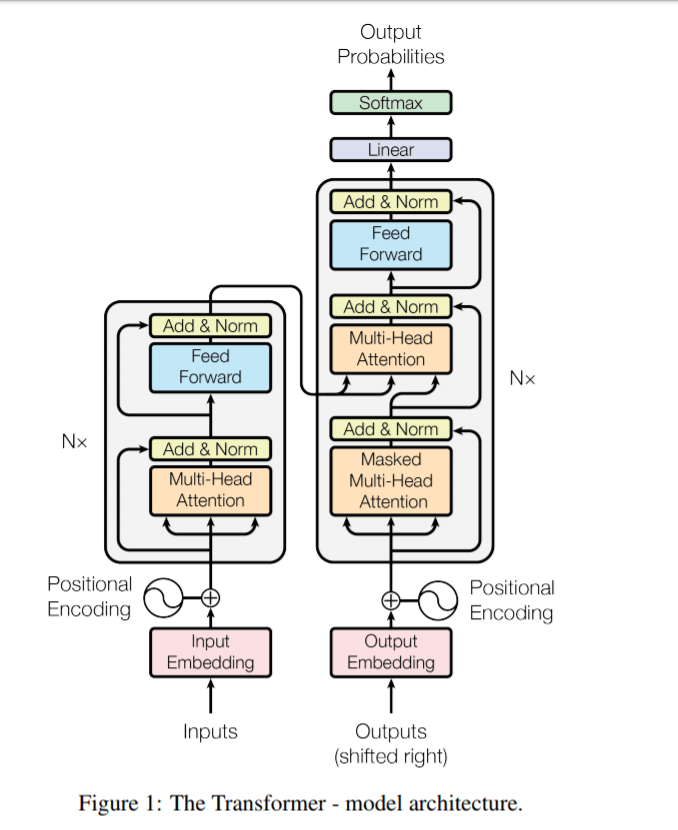


In [ ]:
!pip install tensorflow==2.3.1
!pip install tensorflow-datasets==4.1.0

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
#provides functions and variables which are used to manipulate different parts of the Python Runtime Environment.
import sys
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt


In [ ]:
print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.3.1


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


# Dataset
**`Cornell Movie-Dialogs Corpus`**
A large metadata-rich collection of fictional conversations extracted from raw movie scripts. (220,579 conversational exchanges between 10,292 pairs of movie characters in 617 movies).

# Speaker-level information
speakers in this dataset are movie characters. We take speaker index from the original data release as the speaker name. For each character, we further provide the following information as speaker-level metadata:

character_name: name of the character in the movie
movie_idx: index of the movie this character appears in
movie_name: title of the movie
gender: gender of the character (“?” for unlabeled cases)
credit_pos: position on movie credits (“?” for unlabeled cases)

# **Utterance-level information**

For each utterance, we provide:

id: index of the utterance
speaker: the speaker who authored the utterance
conversation_id: id of the first utterance in the conversation this utterance belongs to
reply_to: id of the utterance to which this utterance replies to (None if the utterance is not a reply)
timestamp: time of the utterance
text: textual content of the utterance

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9920512/9916637 [==============================] - 2s 0us/step


In [ ]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

# **Data Preprocessing**

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
#A contraction is a shortened version of the written and spoken 
#forms of a word, syllable, or word group, created by omission of internal letters and sounds.
#to clear abbreviations

  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()

In [ ]:
print('Sample question: {}'.format(questions[2]))
print('Sample answer: {}'.format(answers[40]))

Sample question: not the hacking and gagging and spitting part . please .
Sample answer: okay you are gonna need to learn how to lie .


In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2


In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 271, 3, 271, 3, 141, 385, 173, 3, 40, 4, 611, 2, 11, 864, 30, 2021, 3086, 1]


In [ ]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8279
Number of samples: 44131
